In [1]:
import torch
import sys
sys.path.append("../src")
sys.path.append("../src/models")
from train import getModel, prepare_dataset
from experiments import experiments
import argparse
import tqdm
import numpy as np
from datasets.ConcatDataset import ConcatDataset
import pandas as pd
import geopandas as gpd
import sklearn.metrics
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import sklearn

figure_path = "/tmp/tsne"#"/home/marc/projects/ISPRS_CropTypeMapping/images/tsne"

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import tqdm

tumorange=(0.89019608, 0.44705882, 0.13333333, 1)
tumblue=(0., 0.39607843, 0.74117647,1)
tumblack=(0,0,0,1)

def attn_plots(ax, arr, mode="conn"):
    assert mode in ["conn","adj"]
    
    if mode =="adj":
        ax.imshow(arr)
        ax.axis('off')
        ax.set_xlabel("out")
        ax.set_ylabel("in")
    
    elif mode=="conn":
        N = arr.shape[1]
        
        ax.set_xlim(0,N)
        for o in tqdm.tqdm(range(N)):
            for i in range(N):
                ax.add_line(Line2D([i,o], [0,1],color=(tumblue[0],tumblue[1],tumblue[2],arr[o,i,0]*.5)))
                ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
                ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
        ax.axis('off')
    return ax
    

In [4]:
def append_store(feature, fname):
    if not os.path.exists(fname):
        print(f"{fname} does not exist. creating...")
        np.save(fname,feature)
    else:
        db = np.vstack([np.load(fname),feature])
        print(f"adding feature to {fname}. now {db.shape[0]}")
        np.save(fname,db)

def attention_hook(module, inp, out):
    
    enc_output, enc_slf_attn = out
    
    for i in range(enc_slf_attn.shape[0]):
        np.savetxt("/tmp/enc_slf_attn_{}.txt".format(i), enc_slf_attn[i].cpu().detach().numpy(), fmt="%.4f")
    np.savetxt("/tmp/enc_output.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    
    enc_input, enc_input, enc_input = inp
    
    fig,axs = plt.subplots(3,figsize=(12,6))
    axs[0].plot(enc_input[0].cpu().detach().numpy())
    axs[0].set_title("input")
    
    axs[1] = attn_plots(axs[1], enc_slf_attn.transpose(2,0).cpu().detach().numpy(), mode="conn")
    
    axs[1].set_title("attention scores")
    axs[2].set_title("output")
    axs[2].plot(enc_output[0].cpu().detach().numpy())

    
def feature_hook(module, inp, out,name="layer_x"):
    enc_out = out[0].cpu().detach().numpy()
    features = enc_out.mean(1)
    store_name=f"/tmp/{name}.npy"
    append_store(features,fname=store_name)
    
def feature_hook0(module, inp, out):
    feature_hook(module, inp, out,"layer_0")
    
def feature_hook1(module, inp, out):
    feature_hook(module, inp, out,"layer_1")
    
def feature_hook2(module, inp, out):
    feature_hook(module, inp, out,"layer_2")
    
def outfeature_hook(module, inp, out):
    name="outlinear"
    enc_inp = inp[0].cpu().detach().numpy()
    features = enc_inp.mean(2)
    store_name=f"/tmp/{name}.npy"
    append_store(features,fname=store_name)
   
model.encoder.layer_stack[0].register_forward_hook(feature_hook0)
model.encoder.layer_stack[1].register_forward_hook(feature_hook1)
model.encoder.layer_stack[2].register_forward_hook(feature_hook2)
model.tempmaxpool.register_forward_hook(outfeature_hook)

def rm(fname):
    if os.path.exists(f"{fname}"):
        print(f"removing {fname}")
        os.remove(f"{fname}")

def rm_all(fld):
    rm(os.path.join(fld,"layer_0.npy"))
    rm(os.path.join(fld,"layer_1.npy"))
    rm(os.path.join(fld,"layer_2.npy"))
    rm(os.path.join(fld,"outlinear.npy"))

In [3]:
def evaluate(model, dataloader):

    probaslist = list()
    targetslist = list()
    idslist = list()
    for iteration, data in tqdm.tqdm(enumerate(dataloader)):
        inputs, targets, ids = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
            model.cuda()
        else:
            model.cpu()

        logprobabilities, deltas, pts, budget = model.forward(inputs.transpose(1, 2))
        probaslist.append(logprobabilities.exp().cpu().detach().numpy())
        targetslist.append(targets.cpu().detach().numpy())
        idslist.append(ids.numpy())

    ids = np.hstack(idslist)
    probas = np.vstack(probaslist)
    targets = np.vstack(targetslist)[:,0]

    return ids, targets, probas

experiment = "isprs_tum_transformer"

args = argparse.Namespace(experiment=experiment, seed=0, batchsize=256, workers=0,hparamset=None)
args = experiments(args)
args.classmapping="/data/BavarianCrops/classmapping.isprs.csv"

args.testregions = args.trainregions = ["holl"]
holltraindataloader, holltestdataloader = prepare_dataset(args)

args.testregions = args.trainregions = ["nowa"]
nowatraindataloader, nowatestdataloader = prepare_dataset(args)

args.testregions = args.trainregions = ["krum"]
krumtraindataloader, krumtestdataloader = prepare_dataset(args)

dataset = ConcatDataset([holltestdataloader.dataset, nowatestdataloader.dataset, krumtestdataloader.dataset])
alldataloader = torch.utils.data.DataLoader(dataset=dataset,batch_size=args.batchsize, num_workers=args.workers)

args.nclasses = holltraindataloader.dataset.nclasses
classname = holltraindataloader.dataset.classname
klassenname = holltraindataloader.dataset.klassenname
args.seqlength = holltraindataloader.dataset.sequencelength
args.input_dims = holltraindataloader.dataset.ndims

model = getModel(args)
model.load(f"/data/isprs/runs/{experiment}/model.pth")

#ids_holl, targets_holl, probas_holl = evaluate(model, holltestdataloader)
#ids_nowa, targets_nowa, probas_nowa = evaluate(model, nowatestdataloader)
#ids_krum, targets_krum, probas_krum = evaluate(model, krumtestdataloader)

#holl = metric(targets_holl, probas_holl.argmax(1))
#nowa = metric(targets_nowa, probas_nowa.argmax(1))
#krum = metric(targets_krum, probas_krum.argmax(1))



Initializing BavarianCropsDataset test partition in holl
read 23 classes
precached dataset files found at /data/BavarianCrops/npy/classmapping.isprs.csv/blocks/holl/test
loaded 9792 samples
Dataset /data/BavarianCrops. region holl. partition test. X:9792x(144, 13), y:(9792,) with 23 classes
Initializing BavarianCropsDataset trainvalid partition in holl
read 23 classes
precached dataset files found at /data/BavarianCrops/npy/classmapping.isprs.csv/blocks/holl/trainvalid
loaded 25308 samples
Dataset /data/BavarianCrops. region holl. partition trainvalid. X:25308x(71, 13), y:(25308,) with 23 classes
setting random seed to 0
Initializing BavarianCropsDataset test partition in nowa
read 23 classes
precached dataset files found at /data/BavarianCrops/npy/classmapping.isprs.csv/blocks/nowa/test
loaded 3572 samples
Dataset /data/BavarianCrops. region nowa. partition test. X:3572x(287, 13), y:(3572,) with 23 classes
Initializing BavarianCropsDataset trainvalid partition in nowa
read 23 classes


{'optimizer_state_dict': {'state': {140243261964224: {'step': 2842,
    'exp_avg': tensor([ 6.9601e-03,  3.5762e-02,  1.9278e-03,  4.0961e-03,  3.8737e-03,
             3.9170e-03, -3.5100e-02, -6.2757e-05, -2.3788e-03, -3.6373e-02,
             3.3343e-03,  3.8225e-02, -3.0282e-03]),
    'exp_avg_sq': tensor([0.0126, 0.1212, 0.0069, 0.0122, 0.0175, 0.0126, 0.0493, 0.0433, 0.0404,
            0.7356, 0.0980, 0.9075, 0.0074])},
   140243262070648: {'step': 2842,
    'exp_avg': tensor([-0.0086, -0.0214,  0.0034, -0.0044, -0.0073, -0.0094,  0.0394, -0.0187,
            -0.0056, -0.0227,  0.0020,  0.0245,  0.0085]),
    'exp_avg_sq': tensor([0.0641, 0.0453, 0.0209, 0.0332, 0.0490, 0.0264, 0.0858, 0.1755, 0.0556,
            0.3624, 0.0525, 0.2982, 0.0186])},
   140243262068632: {'step': 2842,
    'exp_avg': tensor([ 5.5248e-04,  2.0607e-04,  6.1752e-04,  5.9760e-04,  1.3480e-05,
             1.0983e-03, -7.1388e-05,  6.3731e-04,  8.1912e-04,  1.9050e-04,
             9.2223e-04,  1.1083e-0

In [6]:
rm_all("/tmp")
ids, targets, probas = evaluate(model, holltestdataloader)
features_layer_0 = np.load("/tmp/layer_0.npy")
features_layer_1 = np.load("/tmp/layer_1.npy")
features_layer_2 = np.load("/tmp/layer_2.npy")
outlinear = np.load("/tmp/outlinear.npy")
holl = (ids,targets,probas,features_layer_0,features_layer_1,features_layer_2,outlinear)

rm_all("/tmp")
ids, targets, probas = evaluate(model, nowatestdataloader)
features_layer_0 = np.load("/tmp/layer_0.npy")
features_layer_1 = np.load("/tmp/layer_1.npy")
features_layer_2 = np.load("/tmp/layer_2.npy")
outlinear = np.load("/tmp/outlinear.npy")
nowa = (ids,targets,probas,features_layer_0,features_layer_1,features_layer_2,outlinear)

rm_all("/tmp")
ids, targets, probas = evaluate(model, krumtestdataloader)
features_layer_0 = np.load("/tmp/layer_0.npy")
features_layer_1 = np.load("/tmp/layer_1.npy")
features_layer_2 = np.load("/tmp/layer_2.npy")
outlinear = np.load("/tmp/outlinear.npy")
krum = (ids,targets,probas,features_layer_0,features_layer_1,features_layer_2,outlinear)

0it [00:00, ?it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
1it [00:00,  8.62it/s]

removing /tmp/layer_0.npy
removing /tmp/layer_1.npy
removing /tmp/layer_2.npy
removing /tmp/outlinear.npy
/tmp/layer_0.npy does not exist. creating...
/tmp/layer_1.npy does not exist. creating...
/tmp/layer_2.npy does not exist. creating...
/tmp/outlinear.npy does not exist. creating...
adding feature to /tmp/layer_0.npy. now 512
adding feature to /tmp/layer_1.npy. now 512


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
2it [00:00,  8.86it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is no

adding feature to /tmp/layer_2.npy. now 512
adding feature to /tmp/outlinear.npy. now 512
adding feature to /tmp/layer_0.npy. now 768
adding feature to /tmp/layer_1.npy. now 768
adding feature to /tmp/layer_2.npy. now 768
adding feature to /tmp/outlinear.npy. now 768
adding feature to /tmp/layer_0.npy. now 1024
adding feature to /tmp/layer_1.npy. now 1024
adding feature to /tmp/layer_2.npy. now 1024
adding feature to /tmp/outlinear.npy. now 1024


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please us

adding feature to /tmp/layer_0.npy. now 1280
adding feature to /tmp/layer_1.npy. now 1280
adding feature to /tmp/layer_2.npy. now 1280
adding feature to /tmp/outlinear.npy. now 1280
adding feature to /tmp/layer_0.npy. now 1536
adding feature to /tmp/layer_1.npy. now 1536
adding feature to /tmp/layer_2.npy. now 1536
adding feature to /tmp/outlinear.npy. now 1536
adding feature to /tmp/layer_0.npy. now 1792
adding feature to /tmp/layer_1.npy. now 1792


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please us

adding feature to /tmp/layer_2.npy. now 1792
adding feature to /tmp/outlinear.npy. now 1792
adding feature to /tmp/layer_0.npy. now 2048
adding feature to /tmp/layer_1.npy. now 2048
adding feature to /tmp/layer_2.npy. now 2048
adding feature to /tmp/outlinear.npy. now 2048
adding feature to /tmp/layer_0.npy. now 2304
adding feature to /tmp/layer_1.npy. now 2304
adding feature to /tmp/layer_2.npy. now 2304
adding feature to /tmp/outlinear.npy. now 2304


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
10it [00:00, 10.39it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/layer_0.npy. now 2560
adding feature to /tmp/layer_1.npy. now 2560
adding feature to /tmp/layer_2.npy. now 2560
adding feature to /tmp/outlinear.npy. now 2560
adding feature to /tmp/layer_0.npy. now 2816
adding feature to /tmp/layer_1.npy. now 2816
adding feature to /tmp/layer_2.npy. now 2816
adding feature to /tmp/outlinear.npy. now 2816
adding feature to /tmp/layer_0.npy. now 3072


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
12it [00:01, 10.64it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/layer_1.npy. now 3072
adding feature to /tmp/layer_2.npy. now 3072
adding feature to /tmp/outlinear.npy. now 3072
adding feature to /tmp/layer_0.npy. now 3328
adding feature to /tmp/layer_1.npy. now 3328
adding feature to /tmp/layer_2.npy. now 3328
adding feature to /tmp/outlinear.npy. now 3328
adding feature to /tmp/layer_0.npy. now 3584
adding feature to /tmp/layer_1.npy. now 3584
adding feature to /tmp/layer_2.npy. now 3584


14it [00:01, 10.83it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/outlinear.npy. now 3584
adding feature to /tmp/layer_0.npy. now 3840
adding feature to /tmp/layer_1.npy. now 3840
adding feature to /tmp/layer_2.npy. now 3840
adding feature to /tmp/outlinear.npy. now 3840
adding feature to /tmp/layer_0.npy. now 4096
adding feature to /tmp/layer_1.npy. now 4096
adding feature to /tmp/layer_2.npy. now 4096
adding feature to /tmp/outlinear.npy. now 4096


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please us

adding feature to /tmp/layer_0.npy. now 4352
adding feature to /tmp/layer_1.npy. now 4352
adding feature to /tmp/layer_2.npy. now 4352
adding feature to /tmp/outlinear.npy. now 4352
adding feature to /tmp/layer_0.npy. now 4608
adding feature to /tmp/layer_1.npy. now 4608
adding feature to /tmp/layer_2.npy. now 4608
adding feature to /tmp/outlinear.npy. now 4608
adding feature to /tmp/layer_0.npy. now 4864
adding feature to /tmp/layer_1.npy. now 4864


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please us

adding feature to /tmp/layer_2.npy. now 4864
adding feature to /tmp/outlinear.npy. now 4864
adding feature to /tmp/layer_0.npy. now 5120
adding feature to /tmp/layer_1.npy. now 5120
adding feature to /tmp/layer_2.npy. now 5120
adding feature to /tmp/outlinear.npy. now 5120
adding feature to /tmp/layer_0.npy. now 5376
adding feature to /tmp/layer_1.npy. now 5376
adding feature to /tmp/layer_2.npy. now 5376
adding feature to /tmp/outlinear.npy. now 5376


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
22it [00:02, 10.84it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/layer_0.npy. now 5632
adding feature to /tmp/layer_1.npy. now 5632
adding feature to /tmp/layer_2.npy. now 5632
adding feature to /tmp/outlinear.npy. now 5632
adding feature to /tmp/layer_0.npy. now 5888
adding feature to /tmp/layer_1.npy. now 5888
adding feature to /tmp/layer_2.npy. now 5888
adding feature to /tmp/outlinear.npy. now 5888
adding feature to /tmp/layer_0.npy. now 6144


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
24it [00:02, 10.81it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/layer_1.npy. now 6144
adding feature to /tmp/layer_2.npy. now 6144
adding feature to /tmp/outlinear.npy. now 6144
adding feature to /tmp/layer_0.npy. now 6400
adding feature to /tmp/layer_1.npy. now 6400
adding feature to /tmp/layer_2.npy. now 6400
adding feature to /tmp/outlinear.npy. now 6400
adding feature to /tmp/layer_0.npy. now 6656
adding feature to /tmp/layer_1.npy. now 6656


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
26it [00:02, 10.69it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/layer_2.npy. now 6656
adding feature to /tmp/outlinear.npy. now 6656
adding feature to /tmp/layer_0.npy. now 6912
adding feature to /tmp/layer_1.npy. now 6912
adding feature to /tmp/layer_2.npy. now 6912
adding feature to /tmp/outlinear.npy. now 6912


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
28it [00:02,  8.48it/s]

adding feature to /tmp/layer_0.npy. now 7168
adding feature to /tmp/layer_1.npy. now 7168
adding feature to /tmp/layer_2.npy. now 7168
adding feature to /tmp/outlinear.npy. now 7168


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
29it [00:02,  8.42it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/layer_0.npy. now 7424
adding feature to /tmp/layer_1.npy. now 7424
adding feature to /tmp/layer_2.npy. now 7424
adding feature to /tmp/outlinear.npy. now 7424
adding feature to /tmp/layer_0.npy. now 7680
adding feature to /tmp/layer_1.npy. now 7680
adding feature to /tmp/layer_2.npy. now 7680
adding feature to /tmp/outlinear.npy. now 7680


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
31it [00:03,  9.09it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/layer_0.npy. now 7936
adding feature to /tmp/layer_1.npy. now 7936
adding feature to /tmp/layer_2.npy. now 7936
adding feature to /tmp/outlinear.npy. now 7936
adding feature to /tmp/layer_0.npy. now 8192
adding feature to /tmp/layer_1.npy. now 8192
adding feature to /tmp/layer_2.npy. now 8192
adding feature to /tmp/outlinear.npy. now 8192
adding feature to /tmp/layer_0.npy. now 8448


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
33it [00:03,  9.43it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/layer_1.npy. now 8448
adding feature to /tmp/layer_2.npy. now 8448
adding feature to /tmp/outlinear.npy. now 8448
adding feature to /tmp/layer_0.npy. now 8704
adding feature to /tmp/layer_1.npy. now 8704
adding feature to /tmp/layer_2.npy. now 8704
adding feature to /tmp/outlinear.npy. now 8704
adding feature to /tmp/layer_0.npy. now 8960
adding feature to /tmp/layer_1.npy. now 8960


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
35it [00:03,  9.71it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
36it [00:03,  9.77it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.ui

adding feature to /tmp/layer_2.npy. now 8960
adding feature to /tmp/outlinear.npy. now 8960
adding feature to /tmp/layer_0.npy. now 9216
adding feature to /tmp/layer_1.npy. now 9216
adding feature to /tmp/layer_2.npy. now 9216
adding feature to /tmp/outlinear.npy. now 9216
adding feature to /tmp/layer_0.npy. now 9472
adding feature to /tmp/layer_1.npy. now 9472


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
37it [00:03,  9.77it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
38it [00:03,  9.79it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.ui

adding feature to /tmp/layer_2.npy. now 9472
adding feature to /tmp/outlinear.npy. now 9472
adding feature to /tmp/layer_0.npy. now 9728
adding feature to /tmp/layer_1.npy. now 9728
adding feature to /tmp/layer_2.npy. now 9728
adding feature to /tmp/outlinear.npy. now 9728
adding feature to /tmp/layer_0.npy. now 9792
adding feature to /tmp/layer_1.npy. now 9792
adding feature to /tmp/layer_2.npy. now 9792
adding feature to /tmp/outlinear.npy. now 9792
removing /tmp/layer_0.npy
removing /tmp/layer_1.npy
removing /tmp/layer_2.npy
removing /tmp/outlinear.npy


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please us

/tmp/layer_0.npy does not exist. creating...
/tmp/layer_1.npy does not exist. creating...
/tmp/layer_2.npy does not exist. creating...
/tmp/outlinear.npy does not exist. creating...
adding feature to /tmp/layer_0.npy. now 512
adding feature to /tmp/layer_1.npy. now 512
adding feature to /tmp/layer_2.npy. now 512
adding feature to /tmp/outlinear.npy. now 512
adding feature to /tmp/layer_0.npy. now 768
adding feature to /tmp/layer_1.npy. now 768


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
4it [00:00, 11.42it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is no

adding feature to /tmp/layer_2.npy. now 768
adding feature to /tmp/outlinear.npy. now 768
adding feature to /tmp/layer_0.npy. now 1024
adding feature to /tmp/layer_1.npy. now 1024
adding feature to /tmp/layer_2.npy. now 1024
adding feature to /tmp/outlinear.npy. now 1024
adding feature to /tmp/layer_0.npy. now 1280
adding feature to /tmp/layer_1.npy. now 1280
adding feature to /tmp/layer_2.npy. now 1280
adding feature to /tmp/outlinear.npy. now 1280


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
6it [00:00, 11.43it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is no

adding feature to /tmp/layer_0.npy. now 1536
adding feature to /tmp/layer_1.npy. now 1536
adding feature to /tmp/layer_2.npy. now 1536
adding feature to /tmp/outlinear.npy. now 1536
adding feature to /tmp/layer_0.npy. now 1792
adding feature to /tmp/layer_1.npy. now 1792
adding feature to /tmp/layer_2.npy. now 1792
adding feature to /tmp/outlinear.npy. now 1792
adding feature to /tmp/layer_0.npy. now 2048
adding feature to /tmp/layer_1.npy. now 2048


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
8it [00:00, 11.31it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is no

adding feature to /tmp/layer_2.npy. now 2048
adding feature to /tmp/outlinear.npy. now 2048
adding feature to /tmp/layer_0.npy. now 2304
adding feature to /tmp/layer_1.npy. now 2304
adding feature to /tmp/layer_2.npy. now 2304
adding feature to /tmp/outlinear.npy. now 2304
adding feature to /tmp/layer_0.npy. now 2560
adding feature to /tmp/layer_1.npy. now 2560
adding feature to /tmp/layer_2.npy. now 2560
adding feature to /tmp/outlinear.npy. now 2560


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please us

adding feature to /tmp/layer_0.npy. now 2816
adding feature to /tmp/layer_1.npy. now 2816
adding feature to /tmp/layer_2.npy. now 2816
adding feature to /tmp/outlinear.npy. now 2816
adding feature to /tmp/layer_0.npy. now 3072
adding feature to /tmp/layer_1.npy. now 3072
adding feature to /tmp/layer_2.npy. now 3072
adding feature to /tmp/outlinear.npy. now 3072
adding feature to /tmp/layer_0.npy. now 3328
adding feature to /tmp/layer_1.npy. now 3328


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
14it [00:01, 11.11it/s]
0it [00:00, ?it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8,

adding feature to /tmp/layer_2.npy. now 3328
adding feature to /tmp/outlinear.npy. now 3328
adding feature to /tmp/layer_0.npy. now 3572
adding feature to /tmp/layer_1.npy. now 3572
adding feature to /tmp/layer_2.npy. now 3572
adding feature to /tmp/outlinear.npy. now 3572
removing /tmp/layer_0.npy
removing /tmp/layer_1.npy
removing /tmp/layer_2.npy
removing /tmp/outlinear.npy
/tmp/layer_0.npy does not exist. creating...
/tmp/layer_1.npy does not exist. creating...


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please us

/tmp/layer_2.npy does not exist. creating...
/tmp/outlinear.npy does not exist. creating...
adding feature to /tmp/layer_0.npy. now 512
adding feature to /tmp/layer_1.npy. now 512
adding feature to /tmp/layer_2.npy. now 512
adding feature to /tmp/outlinear.npy. now 512
adding feature to /tmp/layer_0.npy. now 768
adding feature to /tmp/layer_1.npy. now 768
adding feature to /tmp/layer_2.npy. now 768
adding feature to /tmp/outlinear.npy. now 768


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
4it [00:00, 11.80it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is no

adding feature to /tmp/layer_0.npy. now 1024
adding feature to /tmp/layer_1.npy. now 1024
adding feature to /tmp/layer_2.npy. now 1024
adding feature to /tmp/outlinear.npy. now 1024
adding feature to /tmp/layer_0.npy. now 1280
adding feature to /tmp/layer_1.npy. now 1280
adding feature to /tmp/layer_2.npy. now 1280
adding feature to /tmp/outlinear.npy. now 1280
adding feature to /tmp/layer_0.npy. now 1536
adding feature to /tmp/layer_1.npy. now 1536


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
6it [00:00, 11.69it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is no

adding feature to /tmp/layer_2.npy. now 1536
adding feature to /tmp/outlinear.npy. now 1536
adding feature to /tmp/layer_0.npy. now 1792
adding feature to /tmp/layer_1.npy. now 1792
adding feature to /tmp/layer_2.npy. now 1792
adding feature to /tmp/outlinear.npy. now 1792
adding feature to /tmp/layer_0.npy. now 2048
adding feature to /tmp/layer_1.npy. now 2048
adding feature to /tmp/layer_2.npy. now 2048
adding feature to /tmp/outlinear.npy. now 2048


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please us

adding feature to /tmp/layer_0.npy. now 2304
adding feature to /tmp/layer_1.npy. now 2304
adding feature to /tmp/layer_2.npy. now 2304
adding feature to /tmp/outlinear.npy. now 2304
adding feature to /tmp/layer_0.npy. now 2560
adding feature to /tmp/layer_1.npy. now 2560
adding feature to /tmp/layer_2.npy. now 2560
adding feature to /tmp/outlinear.npy. now 2560
adding feature to /tmp/layer_0.npy. now 2816
adding feature to /tmp/layer_1.npy. now 2816


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
12it [00:01, 11.40it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/layer_2.npy. now 2816
adding feature to /tmp/outlinear.npy. now 2816
adding feature to /tmp/layer_0.npy. now 3072
adding feature to /tmp/layer_1.npy. now 3072
adding feature to /tmp/layer_2.npy. now 3072
adding feature to /tmp/outlinear.npy. now 3072
adding feature to /tmp/layer_0.npy. now 3328
adding feature to /tmp/layer_1.npy. now 3328
adding feature to /tmp/layer_2.npy. now 3328
adding feature to /tmp/outlinear.npy. now 3328


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
14it [00:01, 11.31it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is n

adding feature to /tmp/layer_0.npy. now 3584
adding feature to /tmp/layer_1.npy. now 3584
adding feature to /tmp/layer_2.npy. now 3584
adding feature to /tmp/outlinear.npy. now 3584
adding feature to /tmp/layer_0.npy. now 3840
adding feature to /tmp/layer_1.npy. now 3840
adding feature to /tmp/layer_2.npy. now 3840
adding feature to /tmp/outlinear.npy. now 3840
adding feature to /tmp/layer_0.npy. now 4096
adding feature to /tmp/layer_1.npy. now 4096


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
16it [00:01, 11.29it/s]/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
17it [00:01, 11.45it/s]

adding feature to /tmp/layer_2.npy. now 4096
adding feature to /tmp/outlinear.npy. now 4096
adding feature to /tmp/layer_0.npy. now 4306
adding feature to /tmp/layer_1.npy. now 4306
adding feature to /tmp/layer_2.npy. now 4306
adding feature to /tmp/outlinear.npy. now 4306


In [7]:
_,holltargets,_,hollfeatures0,hollfeatures1,hollfeatures2, outlinearholl = holl
_,nowatargets,_,nowafeatures0,nowafeatures1,nowafeatures2, outlinearnowa = nowa
_,krumtargets,_,krumfeatures0,krumfeatures1,krumfeatures2, outlinearkrum = krum

# assign each feature an Id for the respective region
hollid = np.ones(hollfeatures2.shape[0],dtype=int)*0
nowaid = np.ones(nowafeatures2.shape[0],dtype=int)*1
krumid = np.ones(krumfeatures2.shape[0],dtype=int)*2

targets = np.hstack([holltargets,nowatargets,krumtargets])
regions = np.hstack([hollid,nowaid,krumid])

In [8]:
def get_uniform_idxs(targets,N_uniform = 50):

    classes = np.unique(targets)
    class_idxs = list()
    idxs = np.array([])
    for c in classes:
        idxs_ = np.argwhere(targets==c)[:N_uniform,0]
        idxs = np.hstack([idxs,idxs_])
    return idxs.astype(int)


def save_plot(fig,fname):
    from matplotlib.backends.backend_pdf import PdfPages
    print(f"writing {fname}")
    with PdfPages(fname) as pdf:
        pdf.savefig(fig,bbox_inches='tight')
    
def save_plot_(fig,fname):
    print(f"writing {fname}")
    fig.savefig(fname,bbox_inches='tight',transparent=True, density=300)

In [9]:
idxs = get_uniform_idxs(targets)

# Fit TSNE on all regions

In [10]:
tumblue  = [0,101,189]
tumblack = [0, 0, 0]
tumbluedark = [0,82,147] 
tumbluelight = [152,198,234] 
tumbluemedium = [100,160,200] 
tumivory = [218,215,203]
tumgreen = [162,173,0]
tumorange = [227,114,34] 
tumaubergine = [105,8,90]
tumturquoise = [0,119,138]
tumgreen = [0,124,48]
tumlimegreen = [103,154,29]
tumyellow = [255,220,0]
tumsand = [249,186,0]
tumredorange = [214,76,19]
tumred = [196,72,27]
tumdarkred = [156,13,22]

cb1 = [252,141,89]
cb2 = [84,39,136]
cb3 = [145,207,96]
cb4 = [153,153,153]
cb5 = [239,138,98]
cb6 = [90,180,172]
customcolor = [0,64,64]

colors = [tumblue, tumblack, tumbluedark, tumbluelight, tumbluemedium, tumivory, tumgreen, tumorange, tumaubergine, tumturquoise, customcolor, tumlimegreen, tumyellow, tumsand, tumredorange, tumred, tumdarkred]
colors = colors + [cb1,cb2,cb3,cb4,cb5,cb6]
colors = np.array(colors)
colors = np.array([np.hstack([c,255]) for c in colors])/255

markers = np.array(["o","v","^","<",">","p","*","D"] * 5)

In [70]:
styles = [
    ['fallow',                tumblack,    '*'],
    ['fallow+flower',         tumblack,    '>'],
    ['alfalfa',               tumgreen,    '*'],
    ['grassland',             tumgreen,    '>'],
    ['proteinplants',         tumbluelight,'*'],
    ['winter wheat',          tumbluedark, '*'],
    ['corn',                  tumred,      '*'],
    ['summer wheat',          tumorange,   '*'],
    ['beetroot',              tumbluelight,'>'],
    ['potatoe',               tumbluelight,'^'],
    ['grassland+machining',   tumgreen,    '^'],
    ['grassland+cattle',      tumgreen,    'D'],
    ['winter spelt',          tumbluedark, '>'],
    ['winter rye',            tumbluedark, '^'],
    ['winter barley',         tumbluedark, 'D'],
    ['summer barley',         tumorange,   '>'],
    ['summer oat',            tumorange,   '^'], 
    ['winter triticale',      tumbluedark, 'o'],
    ['peas',                  tumbluelight,'D'],
    ['beans',                 tumbluelight,'o'],
    ['rapeseed',              tumsand,     '*'],
    ['summer oats (gps)',     tumorange,   'D'],
    ['winter triticale (gps)',tumbluedark, 'D']
]
styles = pd.DataFrame(styles).values
classname = styles[:,0]
colors = styles[:,1]
colors = np.array([np.hstack([c,255]) for c in colors])/255
markers = styles[:,2]

In [109]:
def layer_tsne(features, targets, regions):

    idxs = get_uniform_idxs(targets,N_uniform = 200)

    import sklearn.manifold
    tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300)

    emb = tsne.fit_transform(features[idxs])

    fig,ax = plt.subplots(figsize=(8,8))
    classnames = holltestdataloader.dataset.classname
    for c in np.unique(targets):
        mask = targets[idxs] == c
        x = emb[mask,0]
        y = emb[mask,1]
        sc = ax.scatter(x=x, y=y,c=[colors[c]], marker=markers[c], alpha=.5)

    gcs = sc.legend_elements(num=23)[0]
    #*sc.legend_elements(num=23)

    legend_elements = [Line2D([0], [0], marker=marker, color=color, linewidth=0 , label=name, markersize=8) for color, name, marker in zip(colors,classnames, markers)]

    #legend1 = ax.legend(legend_elements,classnames, title="Class")
    #ax.add_artist(legend1)
    ax.set_ylabel("T-SNE 1")
    ax.set_xlabel("T-SNE 2")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    return fig, emb

def layer_tsne_3d(features, targets, regions):
    from mpl_toolkits.mplot3d import Axes3D 

    idxs = get_uniform_idxs(targets,N_uniform = 200)

    import sklearn.manifold
    tsne = sklearn.manifold.TSNE(n_components=3, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300)

    emb = tsne.fit_transform(features[idxs])

    from mpl_toolkits.mplot3d import Axes3D 

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    classnames = holltestdataloader.dataset.classname
    for c in np.unique(targets):
        mask = targets[idxs] == c
        x = emb[mask,0]
        y = emb[mask,1]
        z = emb[mask,2]
        sc = ax.scatter(xs=x, ys=y, zs=z,c=[colors[c]], marker=markers[c])

    #gcs = sc.legend_elements(num=23)[0]
    #*sc.legend_elements(num=23)

    #legend_elements = [Line2D([0], [0], marker=marker, color=color, linewidth=0 , label=name, markersize=8) for color, name, marker in zip(colors,classnames, markers)]

    #legend1 = ax.legend(legend_elements,classnames, title="Class")
    #ax.add_artist(legend1)
    ax.set_ylabel("T-SNE 1")
    ax.set_xlabel("T-SNE 2")
    ax.set_xlabel("T-SNE 3")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_zticks([])
    ax.set_zticklabels([])

    return fig

## TSNE of layer 0

/home/marc/miniconda3/envs/pytorch/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /home/marc/projects/ISPRS_CropTypeMapping/images/tsne/transformer_layer0.pdf


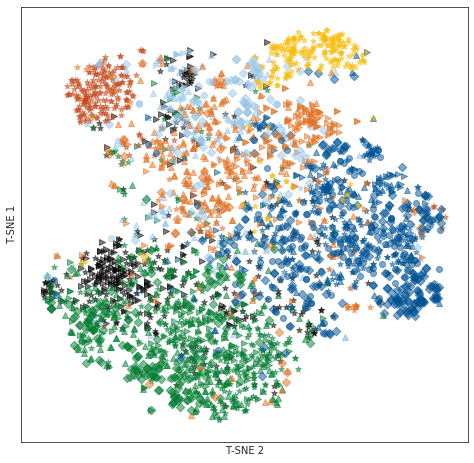

In [110]:
features = np.vstack([hollfeatures0,nowafeatures0,krumfeatures0])
fig,_ = layer_tsne(features, targets, regions)
save_plot(fig,os.path.join(figure_path,"transformer_layer0.pdf"))

## TSNE of layer 1

/home/marc/miniconda3/envs/pytorch/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /home/marc/projects/ISPRS_CropTypeMapping/images/tsne/transformer_layer1.pdf


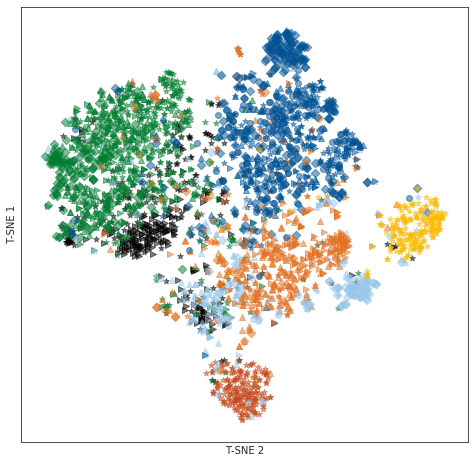

In [111]:
features = np.vstack([hollfeatures1,nowafeatures1,krumfeatures1])
fig,_ = layer_tsne(features, targets, regions)
save_plot(fig,os.path.join(figure_path,"transformer_layer1.pdf"))

## TSNE of Layer 2

/home/marc/miniconda3/envs/pytorch/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /home/marc/projects/ISPRS_CropTypeMapping/images/tsne/transformer_layer2.pdf


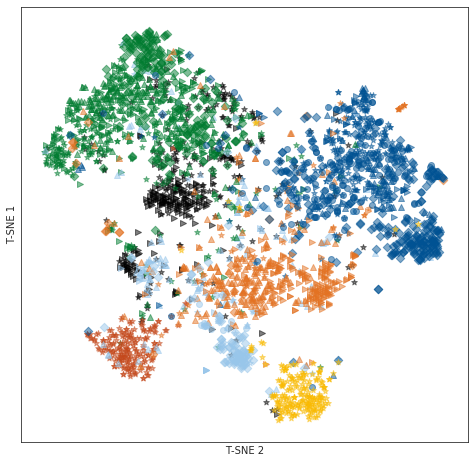

In [112]:
features = np.vstack([hollfeatures2,nowafeatures2,krumfeatures2])
fig,emb = layer_tsne(features, targets, regions)
save_plot(fig,os.path.join(figure_path,"transformer_layer2.pdf"))

## TSNE of outlinear

/home/marc/miniconda3/envs/pytorch/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /home/marc/projects/ISPRS_CropTypeMapping/images/tsne/outlinear.pdf


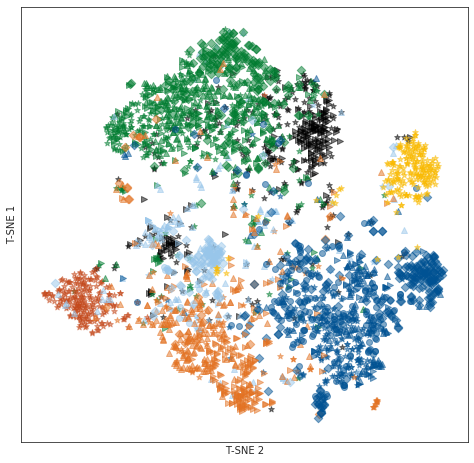

In [113]:
features = np.vstack([outlinearholl,outlinearnowa,outlinearkrum])
fig,emb = layer_tsne(features, targets, regions)
save_plot(fig,os.path.join(figure_path,"outlinear.pdf"))

In [114]:
model

TransformerEncoder(
  (inlayernorm): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
  (convlayernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (outlayernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (inconv): Conv1d(13, 128, kernel_size=(1,), stride=(1,))
  (encoder): Encoder(
    (position_enc): Embedding(71, 128)
    (layer_stack): ModuleList(
      (0): EncoderLayer(
        (slf_attn): MultiHeadAttention(
          (w_qs): Linear(in_features=128, out_features=126, bias=True)
          (w_ks): Linear(in_features=128, out_features=126, bias=True)
          (w_vs): Linear(in_features=128, out_features=126, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (softmax): Softmax(dim=2)
          )
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fc): Linear(in_features=126, out_features=128, bias=True)
          (dropout): Dropout(p=0.262

In [ ]:
%matplotlib notebook
layer_tsne_3d(features, targets, regions)

In [ ]:
def region_tsne(selected_class, ax, features, regions, targets):
    
    tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30.0, 
                                 early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, 
                                 n_iter_without_progress=300)


    mask = targets==selected_class
    selected_features = features[mask]
    selected_regions = regions[mask]
    selected_targets = targets[mask]
    
    idxs = np.arange(selected_regions.shape[0])
    np.random.shuffle(idxs)
    idxs = idxs[:500]
    
    selected_features = selected_features[idxs]
    selected_regions = selected_regions[idxs]
    selected_targets = selected_targets[idxs]
    
    tumorange=np.array([227,114,34,255])/255
    tumblue=np.array([0,101,189,255])/255
    tumbluelight=np.array([152,198,234,255])/255
    tumred=np.array([196,72,27,255])/255

    colors_ = [tumblue,tumorange,tumred]
    regions_ = ["Hollfeld", "Bavarian Forest", "Krumbach"]
    markers_ = markers[:3]
    emb = tsne.fit_transform(selected_features)

    classnames = holltestdataloader.dataset.classname
    for r in np.unique(regions):
        mask = selected_regions == r
        x = emb[mask,0]
        y = emb[mask,1]
        sc = ax.scatter(x=x, y=y,c=[colors_[r]], marker='o', s=40)

    gcs = sc.legend_elements(num=23)[0]
    #*sc.legend_elements(num=23)

    #legend_elements = [Line2D([0], [0], marker='o', color=color, linewidth=0 , label=name, markersize=8) for color, name in zip(colors_, regions_)]

    #legend1 = ax.legend(legend_elements,regions_, title="Class")
    #ax.add_artist(legend1)
    ax.set_ylabel("T-SNE 1")
    ax.set_xlabel("T-SNE 2")
    ax.set_title(classnames[selected_class])
    
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    return ax


In [ ]:
features = np.vstack([hollfeatures2,nowafeatures2,krumfeatures2])
classnames = holltestdataloader.dataset.classname
for i in range(len(classnames)):
    fig,ax = plt.subplots(1, figsize=(4,4))
    ax = region_tsne(i, ax, features, regions, targets)
    name=classnames[i].replace(" ","_")
    save_plot(fig,os.path.join(figure_path,f"{name}.png"))

In [116]:
len(features)

17670